# SimpleVLM Training for Histopathology Segmentation

This notebook trains a **Simple Vision-Language Model** for multi-class histopathology tissue segmentation.

## Model Architecture
- **Vision Encoder**: ResNet50 (ImageNet pretrained)  
- **Text Encoder**: DistilBERT (pretrained)  
- **Fusion**: FiLM (Feature-wise Linear Modulation)  
- **Decoder**: UNet with multi-scale skip connections  
- **Output**: 5-channel masks (one per tissue class)

## Dataset
- **Images**: 2720 histopathology images
- **Classes**: Neoplastic, Inflammatory, Connective_Soft_tissue, Epithelial, Dead
- **Task**: Multi-class multi-label segmentation

In [1]:
# Import required libraries
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from datetime import datetime

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Add SimpleVLM to path
sys.path.append('SimpleVLM')

print("✓ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Libraries imported successfully!
PyTorch version: 2.5.1+cu118
CUDA available: True


c:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Initialize SimpleVLM Model

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Import SimpleVLM components
from vision_encoder import VisionEncoder
from text_encoder import TextEncoder
from fusion import SimpleFusion, MultiScaleFusion
from decoder import UNetDecoder
from model import SimpleVLMSegmenter

# Initialize model
model = SimpleVLMSegmenter(
    vision_backbone='vit_base_patch16_224',  # ViT-B/16 encoder
    vision_pretrained=True,            # Use ImageNet weights
    freeze_vision=False,               # Train vision encoder
    
    text_model='distilbert-base-uncased',  # DistilBERT text encoder  
    freeze_text=False,                 # Train text encoder
    max_text_length=77,
    
    fusion_dim=512,                    # Fusion dimension
    decoder_channels=[256, 128, 64],   # Decoder channels
    num_classes=5,                     # 5 tissue classes
    use_skip_connections=True,         # Use U-Net skip connections
    use_simple_decoder=False           # Use full UNet decoder
).to(device)

print("\n✓ Model initialized!")

# Test forward pass
test_img = torch.randn(2, 3, 224, 224).to(device)
test_texts = ["Segment neoplastic tissue", "Identify inflammatory regions"]

with torch.no_grad():
    test_output = model(test_img, test_texts)
    
print(f"Test output shape: {test_output.shape}")
print(f"Expected: [2, 5, 224, 224] ✓")

Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   8%|8         | 31.5M/378M [00:00<?, ?B/s]

c:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nikhi\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Vision Encoder 'vit_base_patch16_224' feature dimensions: [768, 768, 768]
Text Encoder: distilbert-base-uncased, Hidden dim: 768

SimpleVLM Model Initialized
Vision: vit_base_patch16_224 (pretrained=True, frozen=False)
Text: distilbert-base-uncased (frozen=False)
Fusion dim: 512
Decoder: UNet (classes=5)


✓ Model initialized!
Test output shape: torch.Size([2, 5, 224, 224])
Expected: [2, 5, 224, 224] ✓


In [7]:
# Model information
info = model.get_model_info()

print("="*80)
print("MODEL INFORMATION")
print("="*80)
for key, value in info.items():
    if 'parameters' in key:
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value}")
print("="*80)

MODEL INFORMATION
total_parameters: 160,189,413
trainable_parameters: 160,189,413
num_classes: 5
vision_backbone: vit_base_patch16_224
text_model: distilbert-base-uncased
decoder_type: UNet


## 2. Load Dataset

In [8]:
# Load dataset CSV
df = pd.read_csv('Dataset/Images_With_Unique_Labels_Refer_Segmentation_Task_Small.csv')
print(f"Dataset loaded: {len(df)} samples")

# Parse classes
class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']

for class_name in class_names:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in x else 0)

df['base_name'] = df['image_path'].str.replace('_img.png', '')

# Use Caption column as instruction
if 'instruction' in df.columns:
    df['Caption'] = df['instruction']

print(f"\nClass distribution:")
for col in class_names:
    count = df[col].sum()
    print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")

print(f"\nSample instructions:")
for i in range(3):
    print(f"  {i+1}. {df['Caption'].iloc[i]}")

Dataset loaded: 100 samples

Class distribution:
  Neoplastic: 100 (100.0%)
  Inflammatory: 87 (87.0%)
  Connective_Soft_tissue: 100 (100.0%)
  Epithelial: 8 (8.0%)
  Dead: 3 (3.0%)

Sample instructions:
  1. Circle evident pathology in the Breast attributed to Neoplastic and Inflammatory and Connective_Soft_tissue.
  2. Microscopy of the Breast reveals features consistent with Neoplastic and Inflammatory and Connective_Soft_tissue.
  3. Segment and tag Breast anomalies suggestive of Neoplastic and Connective_Soft_tissue and Inflammatory.


In [9]:
# Dataset class
class HistopathologyDataset(Dataset):
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks', 
                 transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
        self.channel_mapping = {
            'Neoplastic': 0, 'Inflammatory': 1, 'Connective_Soft_tissue': 2,
            'Dead': 3, 'Epithelial': 4
        }
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load masks
        base_name = row['base_name']
        masks = []
        
        for class_name in self.class_names:
            channel_idx = self.channel_mapping[class_name]
            mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
            mask_path = os.path.join(self.mask_dir, mask_filename)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = (mask > 127).astype(np.uint8)
            else:
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            
            masks.append(mask)
        
        masks = np.stack(masks, axis=-1)  # [H, W, C]
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        # Convert to tensors
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        
        if isinstance(masks, np.ndarray):
            masks = torch.from_numpy(masks).permute(2, 0, 1).float()
        
        # Get instruction
        instruction = row['Caption'] if 'Caption' in row else f"Segment {row['classes']} tissue"
        
        return {
            'image': image,
            'masks': masks,
            'instruction': instruction,
            'image_name': row['image_path']
        }

print("✓ Dataset class defined!")

✓ Dataset class defined!


In [10]:
# Data augmentation pipelines
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("✓ Augmentation pipelines defined!")
print(f"  Train: Resize, Flip, Rotate, ColorJitter, Normalize")
print(f"  Val: Resize, Normalize")

✓ Augmentation pipelines defined!
  Train: Resize, Flip, Rotate, ColorJitter, Normalize
  Val: Resize, Normalize


In [11]:
# Split dataset and create data loaders
train_size = int(0.8 * len(df))
val_size = len(df) - train_size

train_df = df[:train_size]
val_df = df[train_size:]

print(f"Dataset split:")
print(f"  Training: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")

# Create datasets
train_dataset = HistopathologyDataset(train_df, transform=train_transform)
val_dataset = HistopathologyDataset(val_df, transform=val_transform)

# Custom collate function for text processing
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    masks = torch.stack([item['masks'] for item in batch])
    instructions = [item['instruction'] for item in batch]
    image_names = [item['image_name'] for item in batch]
    
    return {
        'images': images,
        'masks': masks,
        'instructions': instructions,
        'image_names': image_names
    }

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=0, collate_fn=collate_fn)

print(f"\n✓ Data loaders created!")
print(f"  Batch size: {batch_size}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

Dataset split:
  Training: 80 samples
  Validation: 20 samples

✓ Data loaders created!
  Batch size: 8
  Training batches: 10
  Validation batches: 3


## 3. Define Loss Functions and Metrics

In [16]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred_flat = pred.reshape(pred.size(0), -1)
        target_flat = target.reshape(target.size(0), -1)
        
        intersection = (pred_flat * target_flat).sum(1)
        dice = (2. * intersection + self.smooth) / (pred_flat.sum(1) + target_flat.sum(1) + self.smooth)
        
        return 1 - dice.mean()

# Combined Loss
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

# Metrics
def dice_score(pred, target, per_class=False, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    if per_class:
        # Calculate Dice for each class
        dice_scores = []
        for c in range(pred.shape[1]):
            pred_c = pred[:, c].reshape(-1)
            target_c = target[:, c].reshape(-1)
            intersection = (pred_c * target_c).sum()
            dice = (2. * intersection + smooth) / (pred_c.sum() + target_c.sum() + smooth)
            dice_scores.append(dice.item())
        return torch.tensor(dice_scores)
    else:
        pred_flat = pred.reshape(pred.size(0), -1)
        target_flat = target.reshape(target.size(0), -1)
        intersection = (pred_flat * target_flat).sum(1)
        dice = (2. * intersection + smooth) / (pred_flat.sum(1) + target_flat.sum(1) + smooth)
        return dice.mean()

def iou_score(pred, target, per_class=False, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    if per_class:
        # Calculate IoU for each class
        iou_scores = []
        for c in range(pred.shape[1]):
            pred_c = pred[:, c].reshape(-1)
            target_c = target[:, c].reshape(-1)
            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum() - intersection
            iou = (intersection + smooth) / (union + smooth)
            iou_scores.append(iou.item())
        return torch.tensor(iou_scores)
    else:
        pred_flat = pred.reshape(pred.size(0), -1)
        target_flat = target.reshape(target.size(0), -1)
        intersection = (pred_flat * target_flat).sum(1)
        union = pred_flat.sum(1) + target_flat.sum(1) - intersection
        iou = (intersection + smooth) / (union + smooth)
        return iou.mean()

print("✓ Loss functions and metrics defined!")
print("  Loss: Combined BCE + Dice")
print("  Metrics: Dice Score, IoU Score (per-class support)")

✓ Loss functions and metrics defined!
  Loss: Combined BCE + Dice
  Metrics: Dice Score, IoU Score (per-class support)


## 4. Training Setup

In [13]:
# Training configuration
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 10
best_val_dice = 0.0
best_model_path = 'best_simple_vlm_model.pth'

class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']

# History tracking
history = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
    'train_iou': [], 'val_iou': []
}

print("✓ Training configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print(f"  Scheduler: CosineAnnealingLR")
print(f"  Loss: Combined BCE + Dice (0.5/0.5)")
print(f"  Device: {device}")

✓ Training configuration:
  Epochs: 10
  Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
  Scheduler: CosineAnnealingLR
  Loss: Combined BCE + Dice (0.5/0.5)
  Device: cuda


In [14]:
# Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_dice_scores = []
    all_iou_scores = []
    
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        images = batch['images'].to(device)
        masks = batch['masks'].to(device)
        instructions = batch['instructions']
        
        optimizer.zero_grad()
        
        outputs = model(images, instructions)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate metrics (per-class)
        with torch.no_grad():
            dice = dice_score(outputs, masks, per_class=True)
            iou = iou_score(outputs, masks, per_class=True)
            all_dice_scores.append(dice)
            all_iou_scores.append(iou)
        
        pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = running_loss / len(dataloader)
    avg_dice = torch.stack(all_dice_scores).mean(0)  # [5]
    avg_iou = torch.stack(all_iou_scores).mean(0)    # [5]
    
    return avg_loss, avg_dice, avg_iou

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_dice_scores = []
    all_iou_scores = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch in pbar:
            images = batch['images'].to(device)
            masks = batch['masks'].to(device)
            instructions = batch['instructions']
            
            outputs = model(images, instructions)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item()
            
            # Calculate metrics (per-class)
            dice = dice_score(outputs, masks, per_class=True)
            iou = iou_score(outputs, masks, per_class=True)
            all_dice_scores.append(dice)
            all_iou_scores.append(iou)
            
            pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = running_loss / len(dataloader)
    avg_dice = torch.stack(all_dice_scores).mean(0)  # [5]
    avg_iou = torch.stack(all_iou_scores).mean(0)    # [5]
    
    return avg_loss, avg_dice, avg_iou

print("✓ Training and validation functions defined!")

✓ Training and validation functions defined!


## 5. Train the Model

In [17]:
# Main training loop
print(f"\n{'='*80}")
print(f"Starting Training - SimpleVLM Model")
print(f"{'='*80}\n")

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"{'-'*80}")
    
    # Train
    train_loss, train_dice, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice.mean().item())
    history['val_dice'].append(val_dice.mean().item())
    history['train_iou'].append(train_iou.mean().item())
    history['val_iou'].append(val_iou.mean().item())
    
    # Print results
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Train Dice: {train_dice.mean():.4f} | Val Dice: {val_dice.mean():.4f}")
    print(f"  Train IoU:  {train_iou.mean():.4f} | Val IoU:  {val_iou.mean():.4f}")
    
    # Per-class metrics
    print(f"\nPer-Class Validation Metrics:")
    print(f"  {'Class':<25} {'Dice':>10} {'IoU':>10}")
    print(f"  {'-'*47}")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name:<25} {val_dice[i]:>10.4f} {val_iou[i]:>10.4f}")
    print(f"  {'-'*47}")
    print(f"  {'Mean':<25} {val_dice.mean():>10.4f} {val_iou.mean():>10.4f}")
    
    # Save best model
    if val_dice.mean() > best_val_dice:
        best_val_dice = val_dice.mean()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': best_val_dice,
            'val_dice_per_class': val_dice,
            'val_iou_per_class': val_iou,
        }, best_model_path)
        print(f"\n  ✓ Best model saved! (Val Dice: {best_val_dice:.4f})")

print(f"\n{'='*80}")
print(f"Training Complete!")
print(f"Best Validation Dice: {best_val_dice:.4f}")
print(f"{'='*80}\n")


Starting Training - SimpleVLM Model


Epoch [1/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.8063 | Val Loss: 0.8133
  Train Dice: 0.0479 | Val Dice: 0.0773
  Train IoU:  0.0261 | Val IoU:  0.0723

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.0130     0.0067
  Inflammatory                  0.0003     0.0003
  Connective_Soft_tissue        0.0394     0.0204
  Epithelial                    0.3340     0.3340
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.0773     0.0723

  ✓ Best model saved! (Val Dice: 0.0773)

Epoch [2/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7922 | Val Loss: 0.8142
  Train Dice: 0.0734 | Val Dice: 0.0378
  Train IoU:  0.0409 | Val IoU:  0.0211

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1329     0.0765
  Inflammatory                  0.0002     0.0002
  Connective_Soft_tissue        0.0371     0.0194
  Epithelial                    0.0185     0.0095
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.0378     0.0211

Epoch [3/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7815 | Val Loss: 0.8133
  Train Dice: 0.0736 | Val Dice: 0.0387
  Train IoU:  0.0425 | Val IoU:  0.0218

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1137     0.0677
  Inflammatory                  0.0095     0.0048
  Connective_Soft_tissue        0.0553     0.0290
  Epithelial                    0.0151     0.0077
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.0387     0.0218

Epoch [4/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7697 | Val Loss: 0.8582
  Train Dice: 0.0932 | Val Dice: 0.0423
  Train IoU:  0.0547 | Val IoU:  0.0237

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1084     0.0647
  Inflammatory                  0.0433     0.0224
  Connective_Soft_tissue        0.0502     0.0264
  Epithelial                    0.0097     0.0049
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.0423     0.0237

Epoch [5/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7607 | Val Loss: 0.7964
  Train Dice: 0.0938 | Val Dice: 0.0404
  Train IoU:  0.0560 | Val IoU:  0.0231

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1356     0.0811
  Inflammatory                  0.0271     0.0141
  Connective_Soft_tissue        0.0303     0.0155
  Epithelial                    0.0090     0.0046
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.0404     0.0231

Epoch [6/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7555 | Val Loss: 0.7693
  Train Dice: 0.0993 | Val Dice: 0.0546
  Train IoU:  0.0603 | Val IoU:  0.0310

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1263     0.0774
  Inflammatory                  0.0444     0.0239
  Connective_Soft_tissue        0.0704     0.0368
  Epithelial                    0.0318     0.0168
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.0546     0.0310

Epoch [7/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7531 | Val Loss: 0.7747
  Train Dice: 0.0895 | Val Dice: 0.0490
  Train IoU:  0.0544 | Val IoU:  0.0291

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1675     0.1035
  Inflammatory                  0.0002     0.0002
  Connective_Soft_tissue        0.0641     0.0342
  Epithelial                    0.0130     0.0077
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.0490     0.0291

Epoch [8/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7501 | Val Loss: 0.7505
  Train Dice: 0.0999 | Val Dice: 0.1129
  Train IoU:  0.0616 | Val IoU:  0.0939

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1570     0.0970
  Inflammatory                  0.0003     0.0003
  Connective_Soft_tissue        0.0355     0.0186
  Epithelial                    0.3716     0.3537
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.1129     0.0939

  ✓ Best model saved! (Val Dice: 0.1129)

Epoch [9/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7476 | Val Loss: 0.7508
  Train Dice: 0.1076 | Val Dice: 0.1151
  Train IoU:  0.0666 | Val IoU:  0.0956

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1441     0.0919
  Inflammatory                  0.0003     0.0003
  Connective_Soft_tissue        0.0518     0.0276
  Epithelial                    0.3793     0.3581
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.1151     0.0956

  ✓ Best model saved! (Val Dice: 0.1151)

Epoch [10/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7468 | Val Loss: 0.7483
  Train Dice: 0.0997 | Val Dice: 0.1150
  Train IoU:  0.0618 | Val IoU:  0.0957

Per-Class Validation Metrics:
  Class                           Dice        IoU
  -----------------------------------------------
  Neoplastic                    0.1587     0.1011
  Inflammatory                  0.0003     0.0003
  Connective_Soft_tissue        0.0410     0.0216
  Epithelial                    0.3750     0.3556
  Dead                          0.0000     0.0000
  -----------------------------------------------
  Mean                          0.1150     0.0957

Training Complete!
Best Validation Dice: 0.1151



## 6. Visualize Training History

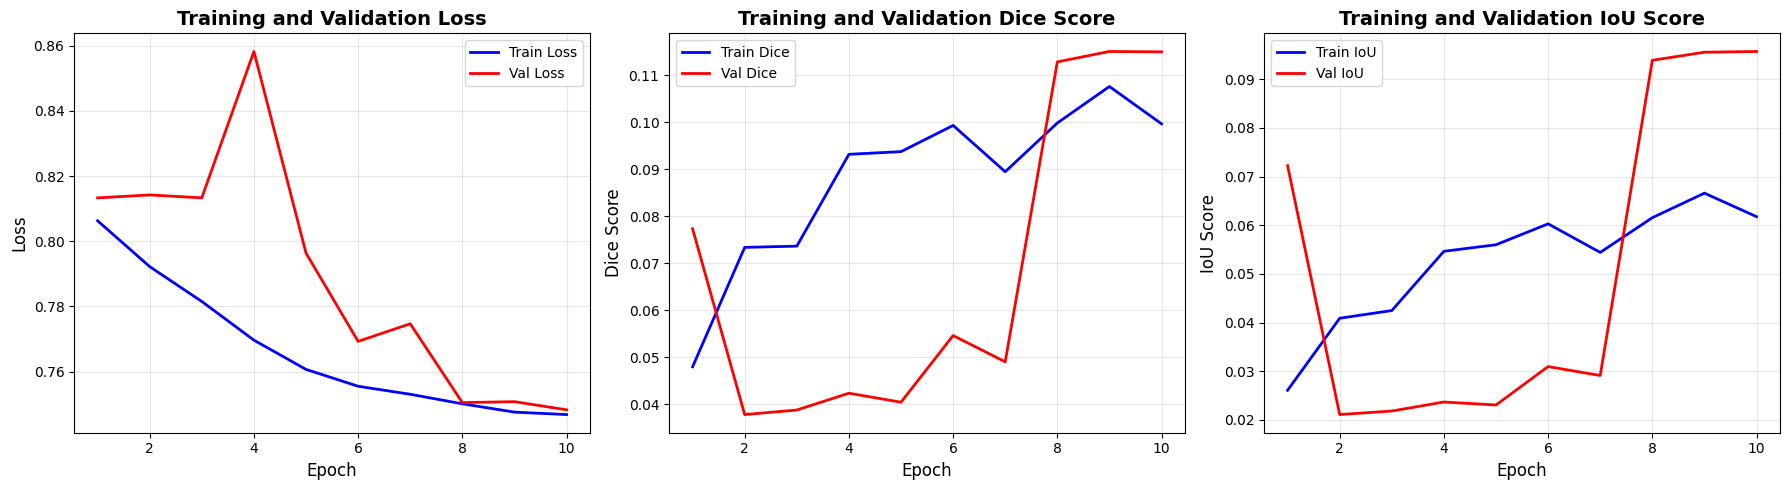

✓ Training history visualized and saved to 'training_history.png'


In [18]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, num_epochs + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Dice Score
axes[1].plot(epochs_range, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
axes[1].plot(epochs_range, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Score', fontsize=12)
axes[1].set_title('Training and Validation Dice Score', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# IoU Score
axes[2].plot(epochs_range, history['train_iou'], 'b-', label='Train IoU', linewidth=2)
axes[2].plot(epochs_range, history['val_iou'], 'r-', label='Val IoU', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('IoU Score', fontsize=12)
axes[2].set_title('Training and Validation IoU Score', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history visualized and saved to 'training_history.png'")

## 7. Visualize Predictions

In [19]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Validation Dice: {checkpoint['val_dice']:.4f}")

# Visualization function
def visualize_predictions(model, dataset, num_samples=4, device='cuda'):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 7, figsize=(20, num_samples * 3))
    
    color_map = {
        'Neoplastic': [255, 0, 0],         # Red
        'Inflammatory': [0, 255, 0],       # Green
        'Connective_Soft_tissue': [0, 0, 255],  # Blue
        'Epithelial': [255, 255, 0],       # Yellow
        'Dead': [255, 0, 255]              # Magenta
    }
    
    with torch.no_grad():
        for idx in range(num_samples):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0).to(device)
            masks_true = sample['masks']
            instruction = sample['instruction']
            
            # Get prediction
            pred = model(image, [instruction])
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float()
            pred = pred.squeeze(0).cpu()
            
            # Denormalize image for visualization
            img_vis = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
            img_vis = img_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_vis = np.clip(img_vis, 0, 1)
            
            # Show original image
            axes[idx, 0].imshow(img_vis)
            axes[idx, 0].set_title('Original Image', fontsize=10)
            axes[idx, 0].axis('off')
            
            # Show ground truth and predictions for each class
            for c, class_name in enumerate(class_names):
                # Ground truth
                axes[idx, c+1].imshow(img_vis)
                axes[idx, c+1].imshow(masks_true[c].numpy(), alpha=0.5, cmap='Reds')
                axes[idx, c+1].set_title(f'GT: {class_name}', fontsize=9)
                axes[idx, c+1].axis('off')
                
                # Prediction
                axes[idx, c+1].imshow(img_vis)
                axes[idx, c+1].imshow(pred[c].numpy(), alpha=0.5, cmap='Blues')
            
            # Overlay visualization
            overlay_true = np.zeros((*masks_true[0].shape, 3), dtype=np.uint8)
            overlay_pred = np.zeros((*pred[0].shape, 3), dtype=np.uint8)
            
            for c, class_name in enumerate(class_names):
                color = color_map[class_name]
                mask_true = masks_true[c].numpy() > 0.5
                mask_pred = pred[c].numpy() > 0.5
                
                for ch in range(3):
                    overlay_true[:, :, ch] = np.where(mask_true, color[ch], overlay_true[:, :, ch])
                    overlay_pred[:, :, ch] = np.where(mask_pred, color[ch], overlay_pred[:, :, ch])
            
            axes[idx, 6].imshow(img_vis)
            axes[idx, 6].imshow(overlay_pred, alpha=0.6)
            axes[idx, 6].set_title('Prediction Overlay', fontsize=10)
            axes[idx, 6].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n✓ Visualization function defined!")

C:\Users\nikhi\AppData\Local\Temp\ipykernel_14008\1820005903.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


✓ Loaded best model from epoch 9
  Validation Dice: 0.1151

✓ Visualization function defined!


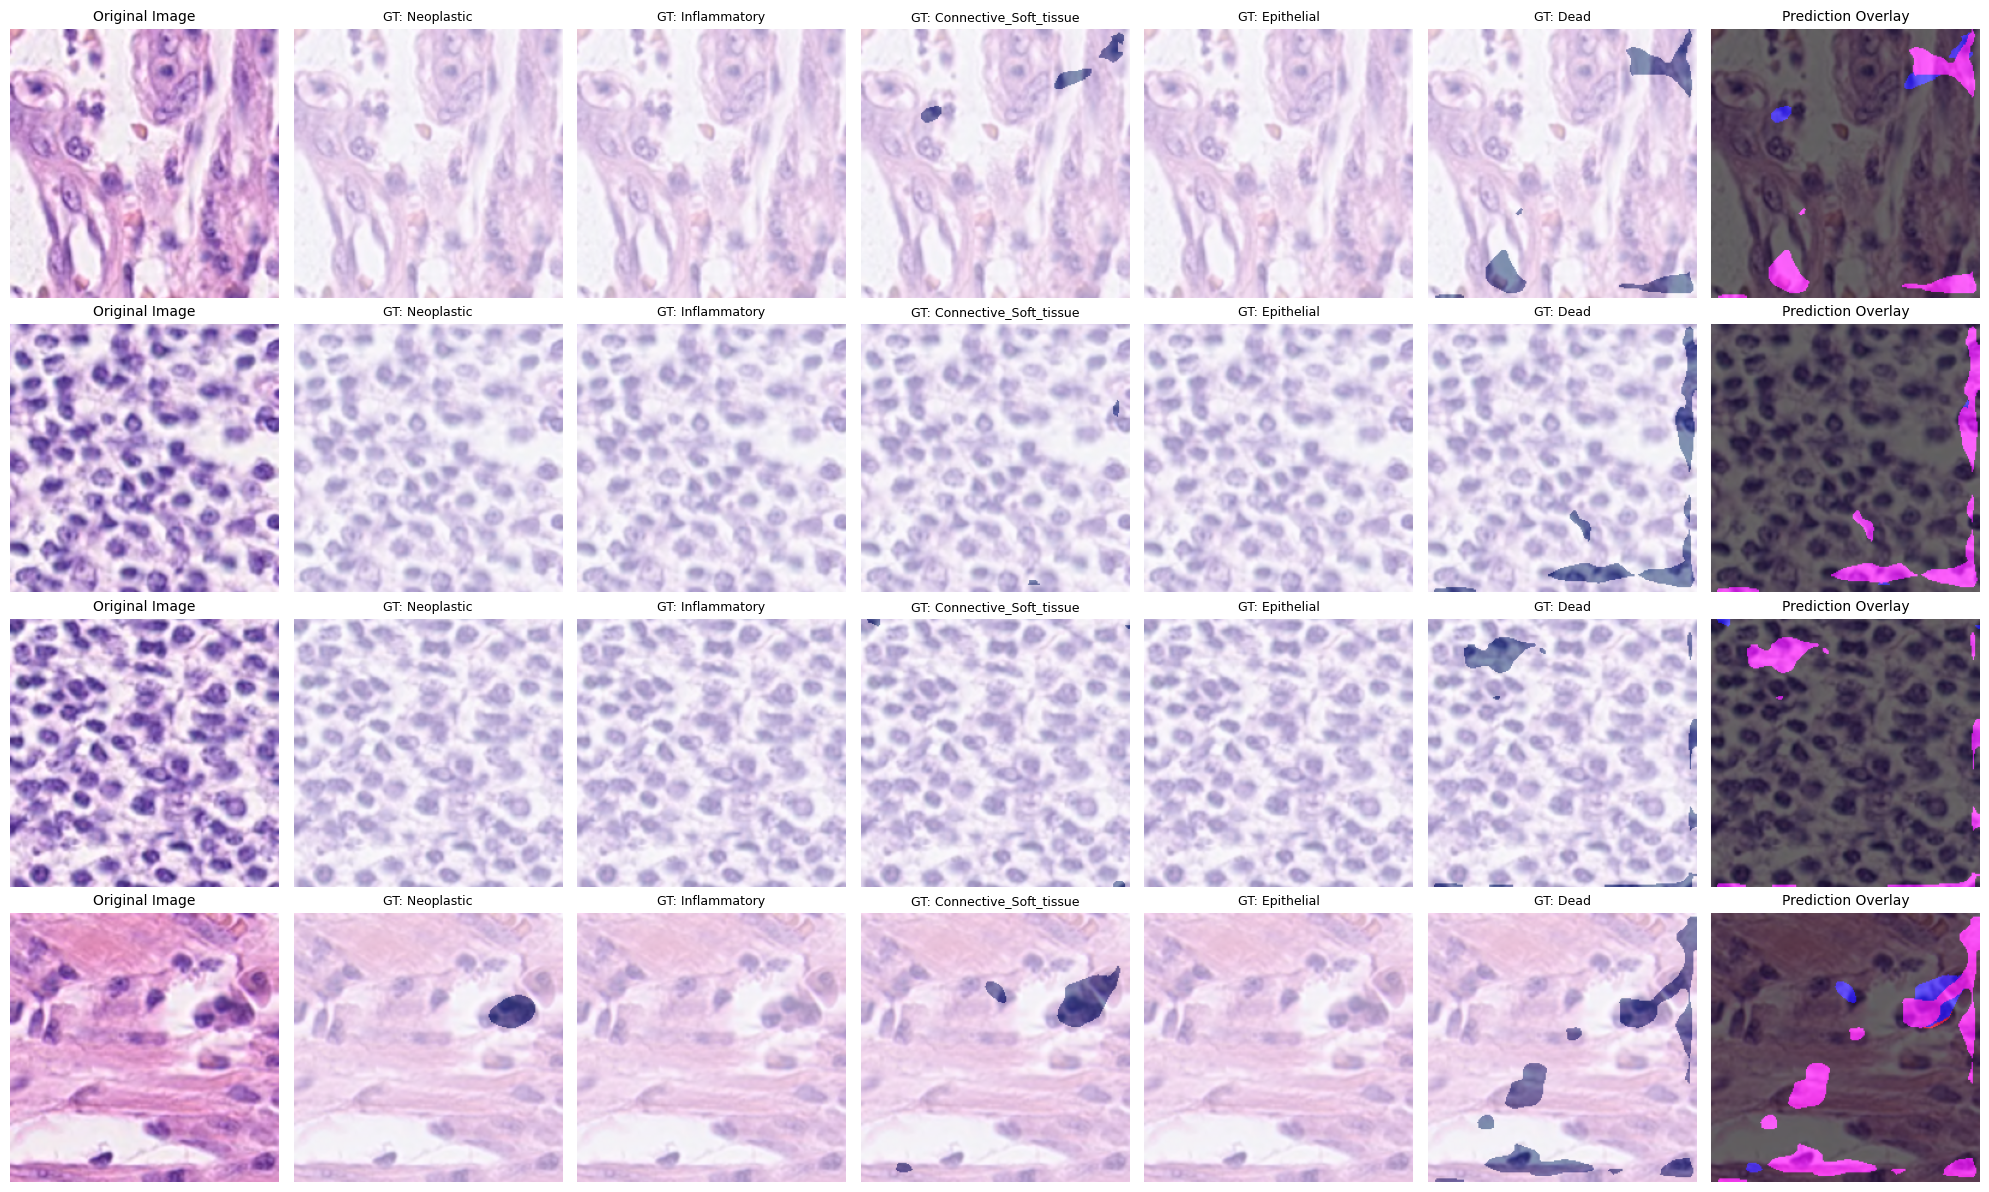

✓ Predictions visualized and saved to 'predictions_visualization.png'


In [20]:
# Visualize predictions on validation set
visualize_predictions(model, val_dataset, num_samples=4, device=device)
print("✓ Predictions visualized and saved to 'predictions_visualization.png'")

## Summary

This notebook trains a **SimpleVLM** model for histopathology tissue segmentation:

**Architecture:**
- Vision: ResNet50 pretrained encoder
- Text: DistilBERT for natural language processing
- Fusion: FiLM (Feature-wise Linear Modulation)
- Decoder: UNet with skip connections
- Output: 5-channel masks (Neoplastic, Inflammatory, Connective, Epithelial, Dead)

**Training:**
- 10 epochs with AdamW optimizer
- Combined BCE + Dice loss
- Per-class Dice and IoU metrics
- Best model saved based on validation Dice score

**Advantages over CIPS-Net:**
- Simpler architecture (~50-70M params vs 120M)
- Faster training and inference
- No complex graph reasoning module
- Easier to debug and modify
- Better modularity (swap encoders/decoders easily)

**Next Steps:**
- Compare performance with CIPS-Net
- Try different backbones (ViT, EfficientNet)
- Experiment with fusion methods (CrossAttention, MultiScale)
- Train on class combinations dataset